In [1025]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree
from imblearn.over_sampling import SMOTE
import numpy as np

RANDOM_STATE = 56
CRITERION = 'gini'
CLASS_WEIGHT = None

In [1026]:
df = pd.read_csv('./gameandgrade.csv')
df.head()

,Sex,School Code,Playing Years,Playing Often,Playing Hours,Playing Games,Parent Revenue,Father Education,Mother Education,Grade
0,0,1,1,2,1,1,4,4,5,77.50
1,1,1,1,3,1,1,1,3,3,83.00
2,0,1,0,0,0,0,1,3,3,80.00
3,0,1,3,5,1,1,2,2,3,45.00
4,1,1,1,1,2,1,1,3,4,85.00


In [1027]:
def grade_rule(grade):
    grade.strip()
    grade = float(grade)
    if grade >= 90:
        return 'A'
    elif grade >= 80:
        return 'B'
    elif grade >= 70:
        return 'C'
    elif grade >= 60:
        return 'D'
    else:
        return 'F'

categories = ['Good', 'Not bad', 'Bad']
def mark_category(mark):
    if mark in ['A', 'B']:
        return 'Good'
    if mark in ['C', 'D']:
        return 'Not bad'
    return 'Bad'

### Нормалізуємо дані

In [1028]:
#У дата сеті присутнє значення для Grade 92..00
df['Grade'] = df['Grade'].str.replace(r'..', '.')
df = df.drop(columns=['School Code'])
# df = df.drop(columns=['Sex'])
# df = df.drop(columns=['Father Education'])
# df = df.drop(columns=['Mother Education'])

In [1029]:
df['mark'] = df['Grade'].apply(grade_rule)
df['Mark Category'] = df['mark'].apply(mark_category)

df.drop(columns=['Grade'], inplace=True)
df.drop(columns=['mark'], inplace=True)
df.head()

,Sex,Playing Years,Playing Often,Playing Hours,Playing Games,Parent Revenue,Father Education,Mother Education,Mark Category
0,0,1,2,1,1,4,4,5,Not bad
1,1,1,3,1,1,1,3,3,Good
2,0,0,0,0,0,1,3,3,Good
3,0,3,5,1,1,2,2,3,Bad
4,1,1,1,2,1,1,3,4,Good


### Розбиваємо дані на тренувальні та тестові

In [1030]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Mark Category']),
    df['Mark Category'],
    test_size=0.4,
    stratify=df['Mark Category'],
    random_state=RANDOM_STATE
)

In [1031]:
print(f'distribution = {df["Mark Category"].value_counts()}')
# X_train, y_train = SMOTE().fit_resample(X_train, y_train)

distribution = Mark Category
Good       392
Not bad    266
Bad        112
Name: count, dtype: int64


### Створюємо дерево рішень (алгоритм CART)

In [1032]:
clf = DecisionTreeClassifier(criterion=CRITERION, class_weight=CLASS_WEIGHT, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=56)

### Визначаємо найкращий параметр alpha для дерева

In [1033]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

alpha_values = {}
ccp_alphas = np.unique(ccp_alphas)
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=alpha, random_state=RANDOM_STATE, min_samples_leaf=10, criterion=CRITERION, class_weight=CLASS_WEIGHT)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred), 'Alpha: ', alpha)
    alpha_values[alpha] = accuracy_score(y_test, y_pred)

best = max(alpha_values, key=alpha_values.get)
print('Best alpha: ', best)

Accuracy:  0.5292207792207793 Alpha:  0.0
Accuracy:  0.5292207792207793 Alpha:  0.00021645021645021537
Accuracy:  0.5292207792207793 Alpha:  0.00023612750885478213
Accuracy:  0.5292207792207793 Alpha:  0.00027548209366391394
Accuracy:  0.5292207792207793 Alpha:  0.00036075036075036097
Accuracy:  0.5292207792207793 Alpha:  0.0005411255411255412
Accuracy:  0.5292207792207793 Alpha:  0.0006184291898577605
Accuracy:  0.5292207792207793 Alpha:  0.0007215007215007215
Accuracy:  0.5292207792207793 Alpha:  0.000901875901875902
Accuracy:  0.5292207792207793 Alpha:  0.0010822510822510823
Accuracy:  0.5292207792207793 Alpha:  0.0010822510822510825
Accuracy:  0.5292207792207793 Alpha:  0.0011544011544011544
Accuracy:  0.5292207792207793 Alpha:  0.0012331103240194137
Accuracy:  0.5292207792207793 Alpha:  0.0012987012987012978
Accuracy:  0.5292207792207793 Alpha:  0.0014242958687403137
Accuracy:  0.5292207792207793 Alpha:  0.001443001443001443
Accuracy:  0.5292207792207793 Alpha:  0.0014667498993517

### Перестроюємо дерево з найкращим параметром alpha

In [1034]:

clf = DecisionTreeClassifier(ccp_alpha=best, criterion=CRITERION, min_samples_leaf=10, max_depth=5, random_state=RANDOM_STATE, class_weight=CLASS_WEIGHT)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0034632034632034623, max_depth=5,
                       min_samples_leaf=10, random_state=56)

### Тестуємо дерево

In [1035]:
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {score:.4f}')
scores = cross_val_score(clf, df.drop(columns=['Mark Category']), df['Mark Category'], cv=5)
print(f"Cross-validation accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
print(classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.5779
Cross-validation accuracy: 0.5065 ± 0.0457
              precision    recall  f1-score   support

         Bad       0.46      0.13      0.21        45
        Good       0.64      0.75      0.69       157
     Not bad       0.48      0.51      0.50       106

    accuracy                           0.58       308
   macro avg       0.53      0.46      0.47       308
weighted avg       0.56      0.58      0.55       308



### Візуалізація дерева

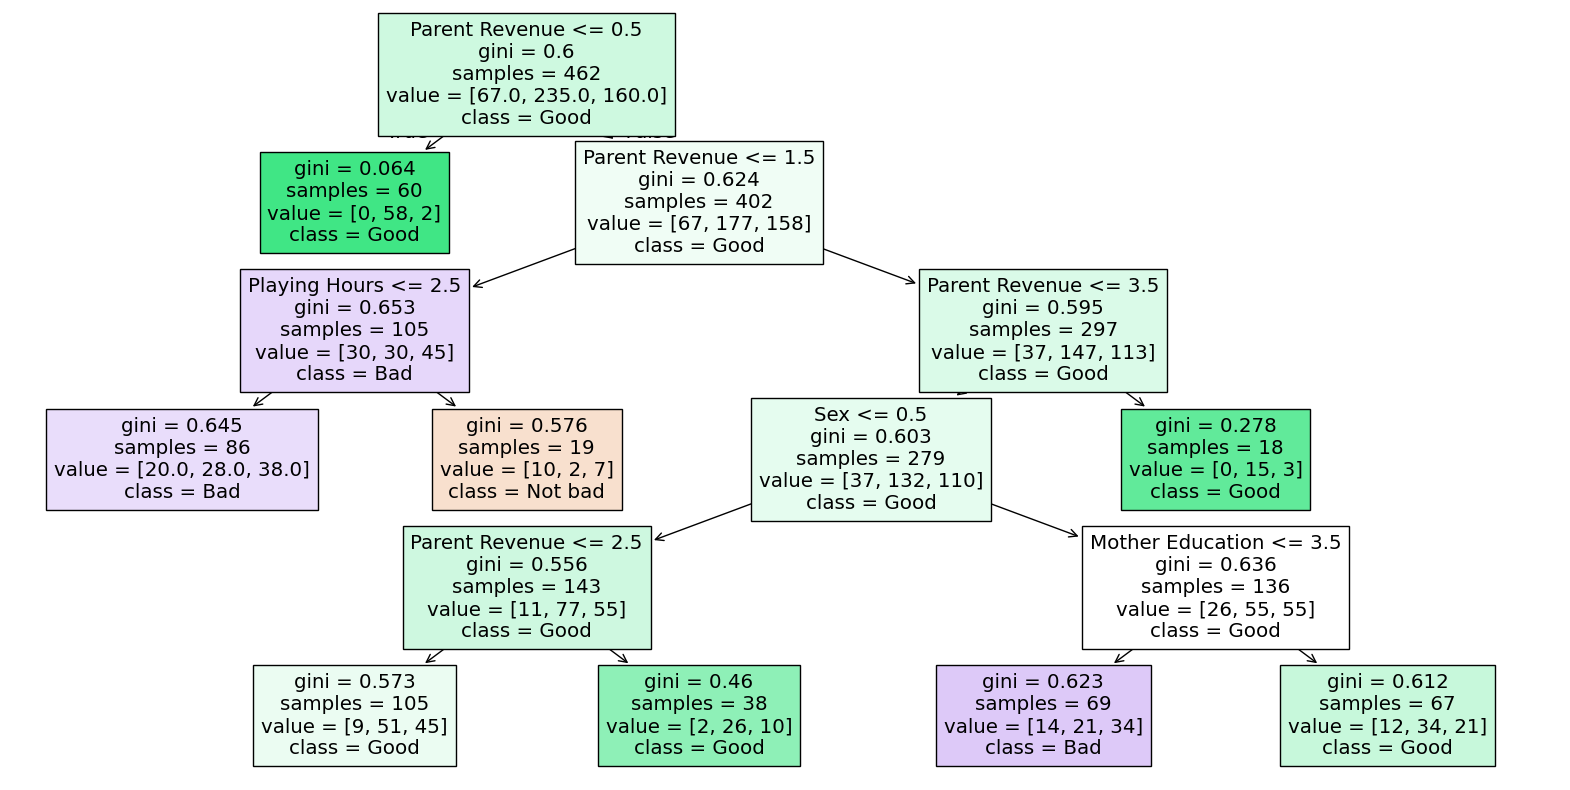

In [1036]:
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, filled=True, feature_names=df.columns, class_names=df['Mark Category'].unique())
plt.show()

In [1037]:
# Create an enhanced comparison dataframe with X parameters
comparison_df = X_test.copy()  # Start with all X parameters
comparison_df['Actual'] = y_test
comparison_df['Predicted'] = y_pred
comparison_df['Correct'] = comparison_df['Actual'] == comparison_df['Predicted']

# Display the DataFrame summary
print(f"Total samples: {len(comparison_df)}")
print(f"Correctly classified: {comparison_df['Correct'].sum()} ({comparison_df['Correct'].mean():.2%})")
print(f"Incorrectly classified: {(~comparison_df['Correct']).sum()} ({(~comparison_df['Correct']).mean():.2%})")

# Show the enhanced comparison table
comparison_df.head(30)

Total samples: 308
Correctly classified: 178 (57.79%)
Incorrectly classified: 130 (42.21%)


,Sex,Playing Years,Playing Often,Playing Hours,Playing Games,Parent Revenue,Father Education,Mother Education,Actual,Predicted,Correct
585,0,0,0,0,0,1,2,2,Good,Not bad,False
73,1,4,3,2,1,3,6,6,Not bad,Good,False
39,1,2,3,3,1,2,2,2,Not bad,Not bad,True
594,1,1,1,1,1,1,5,2,Bad,Not bad,False
166,0,2,5,1,1,2,4,2,Good,Good,True
669,1,3,5,3,1,1,3,4,Good,Bad,False
48,1,2,4,3,1,2,2,2,Not bad,Not bad,True
598,1,2,1,4,1,2,4,3,Not bad,Not bad,True
428,1,2,5,2,1,4,2,2,Good,Good,True
309,1,4,1,5,1,4,5,4,Good,Good,True


In [1038]:
for category in categories:
    correct = comparison_df[(comparison_df['Actual'] == category) & (comparison_df['Correct'] == True)].shape[0]
    incorrect = comparison_df[(comparison_df['Actual'] == category) & (comparison_df['Correct'] == False)].shape[0]
    print(f'Corectly for {category}: {correct} ({correct / (correct + incorrect):.2%})')
    print(f'Incorrect for {category}: {incorrect} ({incorrect / (correct + incorrect):.2%})')

Corectly for Good: 118 (75.16%)
Incorrect for Good: 39 (24.84%)
Corectly for Not bad: 54 (50.94%)
Incorrect for Not bad: 52 (49.06%)
Corectly for Bad: 6 (13.33%)
Incorrect for Bad: 39 (86.67%)
